In [8]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import os
import csv
import pandas as pd

In [ ]:
checkpoint_dir = "path/to/checkpoint"
filepath = "path/to/dir"

learning_rate = 2e-4

In [3]:
logs = "path/to/loss"

In [13]:
log = pd.read_csv(logs)
log

,step,gen_total_loss,gen_gan_loss,gen_l1_loss,disc_loss
0,0,93.199600,0.494656,0.927049,1.796705
1,100,7.291456,0.758064,0.065334,1.477562
2,200,36.171051,0.768628,0.354024,1.325665
3,300,18.891573,0.744036,0.181475,1.364207
4,400,14.000674,0.872739,0.131279,1.342882
...,...,...,...,...,...
995,99500,2.584717,0.757738,0.018270,1.160028
996,99600,6.541282,1.205125,0.053362,1.042472
997,99700,2.417693,0.980407,0.014373,1.351474
998,99800,10.497718,0.823252,0.096745,1.145277


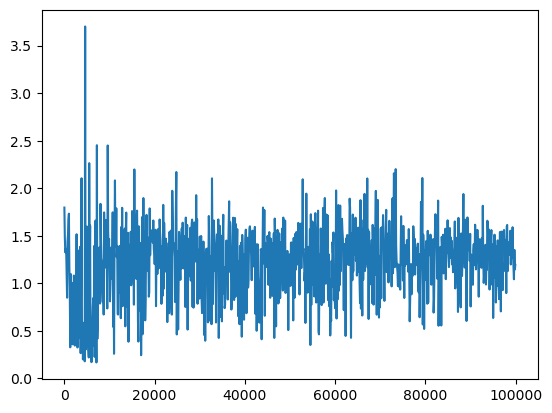

In [16]:
plt.plot(log.step, log.disc_loss)

In [3]:
# Utils
from model.gan import CGAN
from gan_utils.utils import GanUtils

mfn = CGAN()

mfn.gan_para(
        LAMBDA=100,
        OUTPUT_CHANNELS=1,
        filtersize=5,
        beta=0.005,
        learning_rate=2e-4,
        disc_train_iterations=1,
        base_path=filepath, 
        batch_size=1
)

fn = GanUtils(img_size=128)


generator = mfn.Generator()
discriminator = mfn.Discriminator()


gen_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

I0000 00:00:1757311334.890642 1775578 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2209 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [4]:
# Restore checkpoint


checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer,
                                 discriminator_optimizer=disc_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)



print(tf.train.latest_checkpoint(checkpoint_dir))
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

/global/cfs/projectdirs/m2676/users/yuvand/GAN_II/models/cGAN_b0.005_disc1_bs1_lr0.0002_f5_100k/ckpt-20


In [5]:
try:
    test_dataset = tf.data.Dataset.list_files(os.path.join(filepath, "output/test/*.jpg"))
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.Dataset.list_files(os.path.join(filepath, "output/val/*.jpg"))

test_dataset = test_dataset.map(fn.load_image_test)
test_dataset = test_dataset.batch(1)

In [9]:
def rmse(x_hat, x):  return np.sqrt(np.mean((x_hat - x) ** 2))


0.27759334
0.8254513
0.5863581
0.18577354
0.22967583
0.3654188
0.6342556
0.74968123
0.5650907
0.5686986
0.3976436
0.6535358
0.62219536
0.7969746
0.24819595
0.27633366
0.6650504
0.24383833
0.4316321
0.28504872


2025-09-07 23:05:09.880975: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


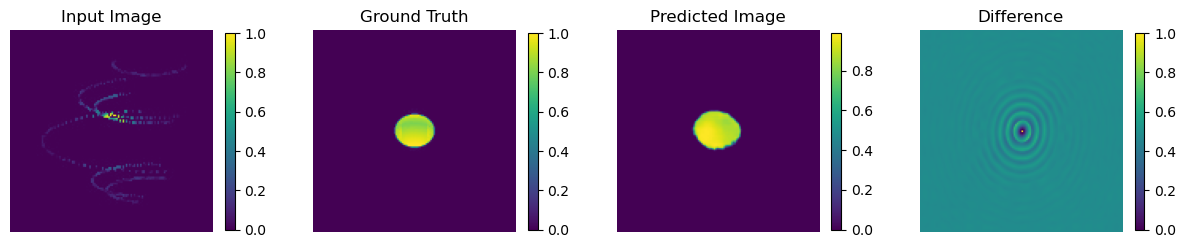

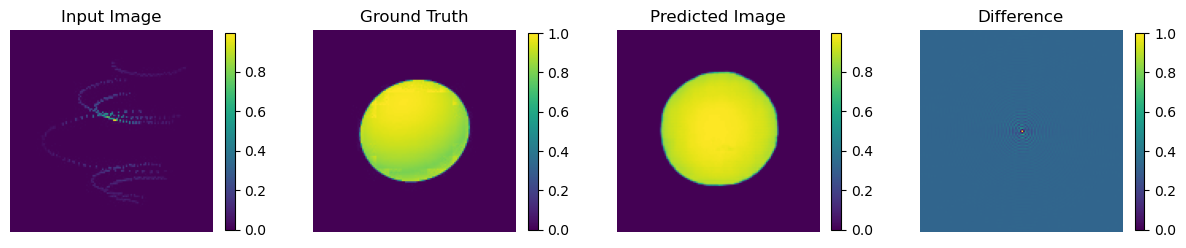

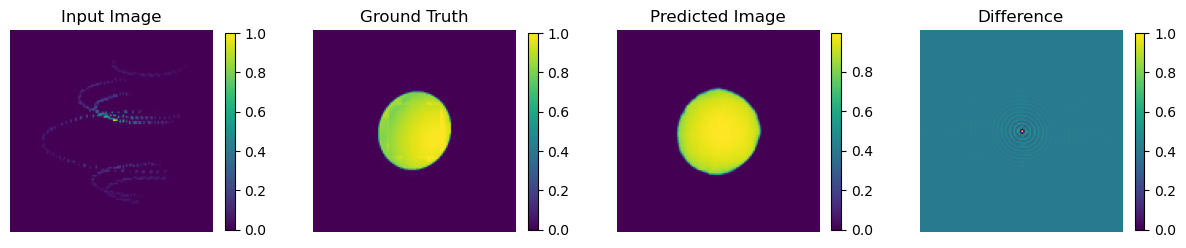

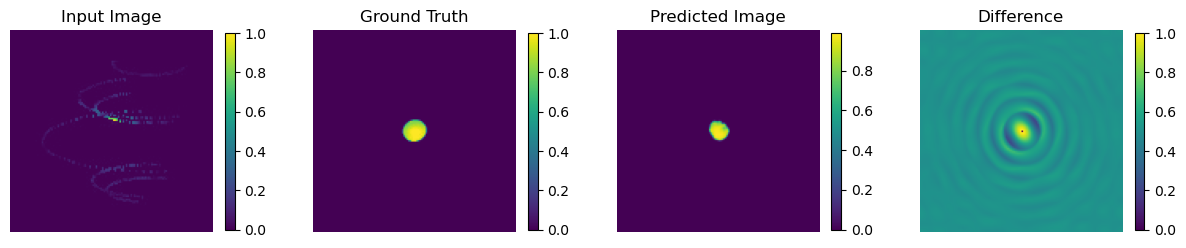

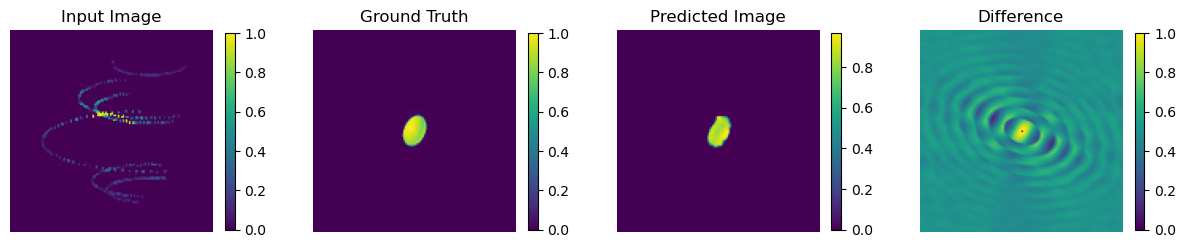

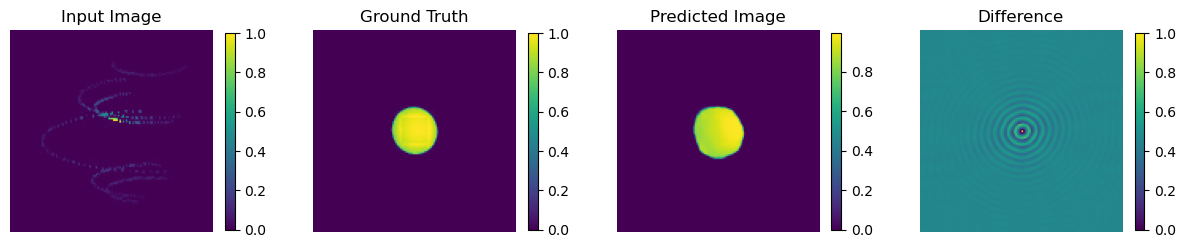

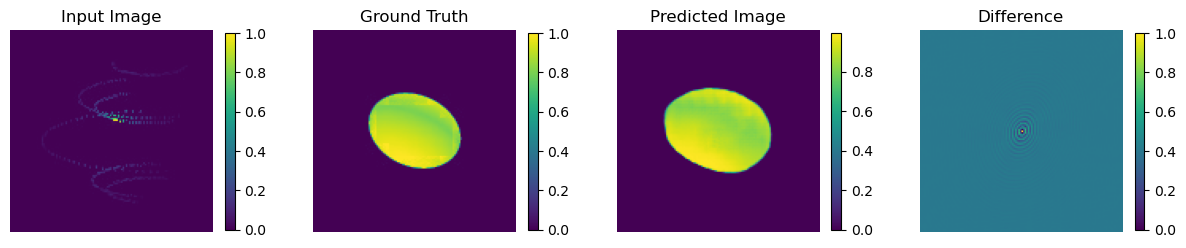

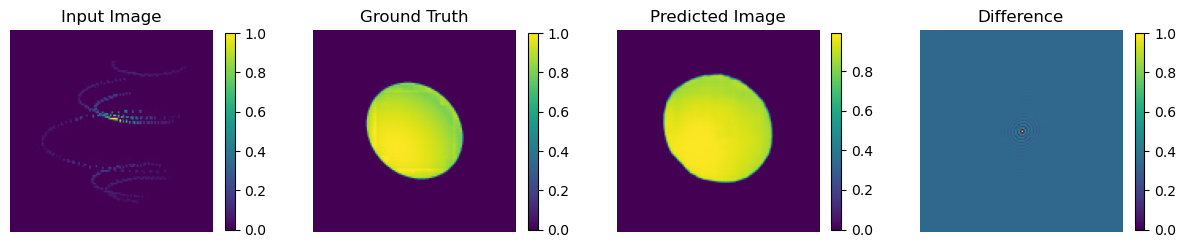

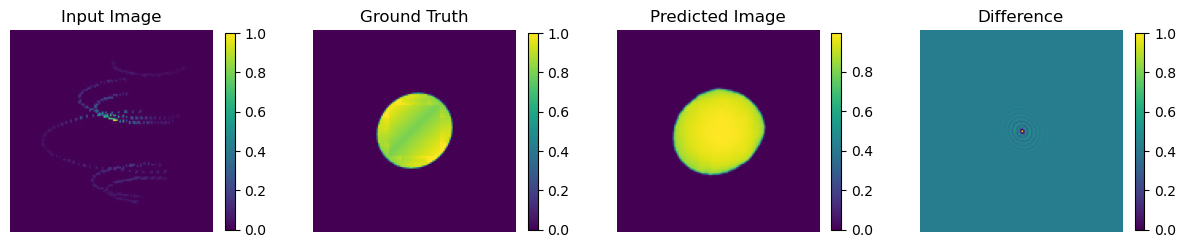

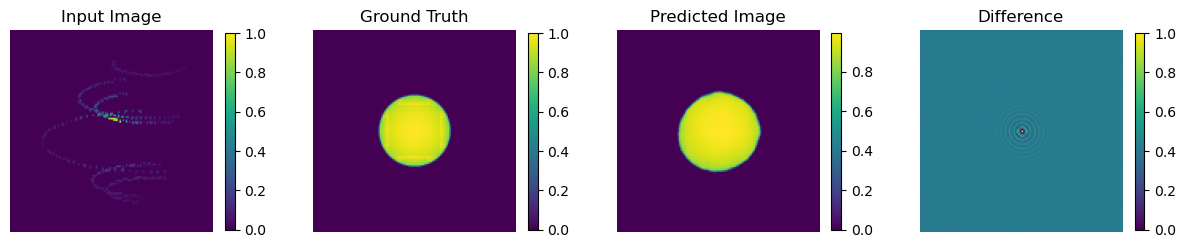

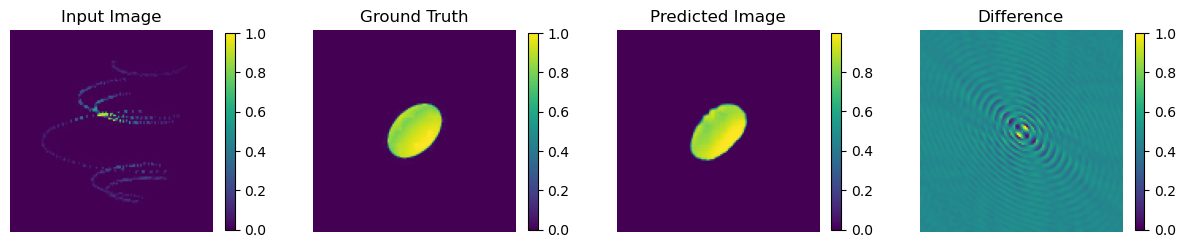

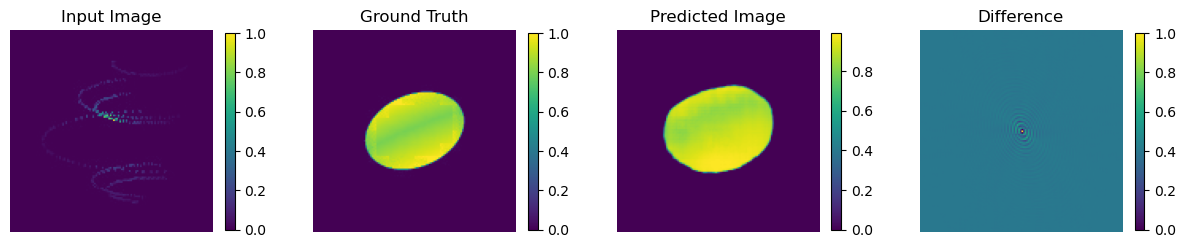

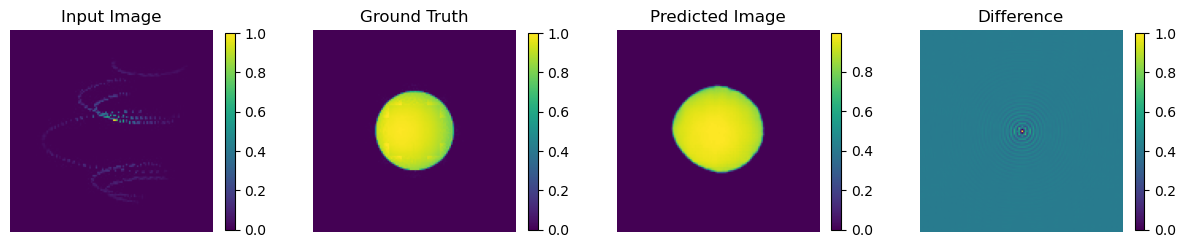

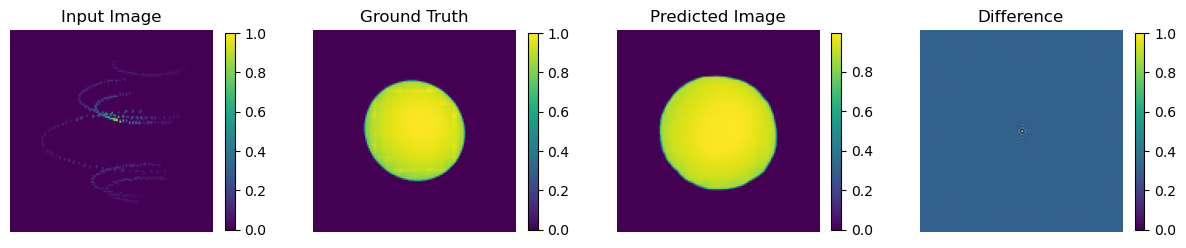

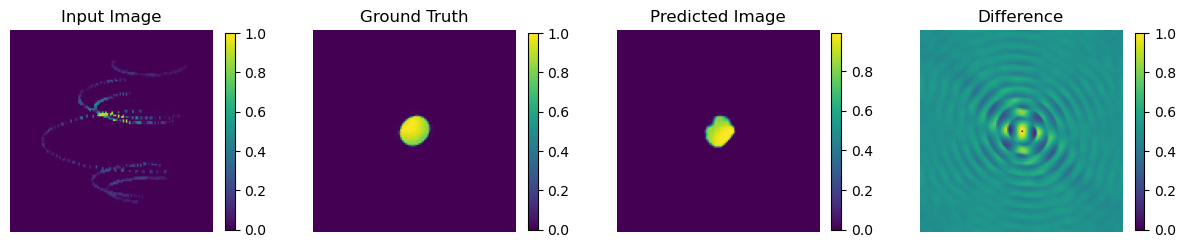

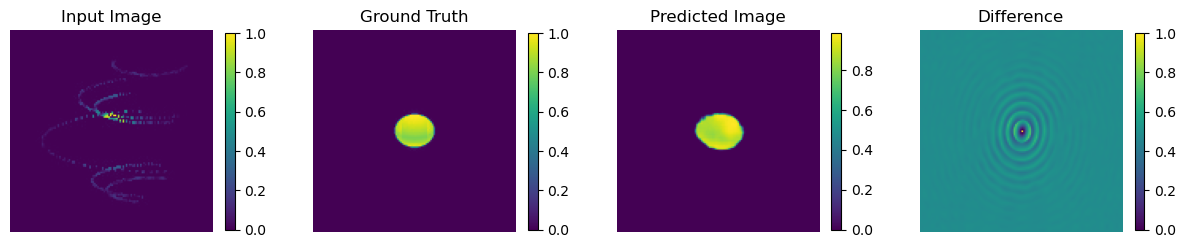

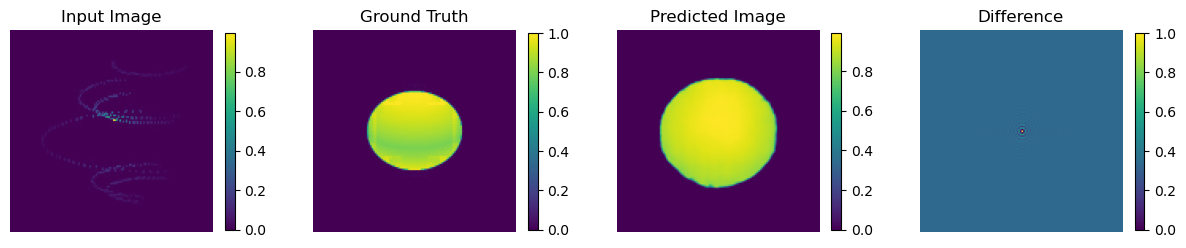

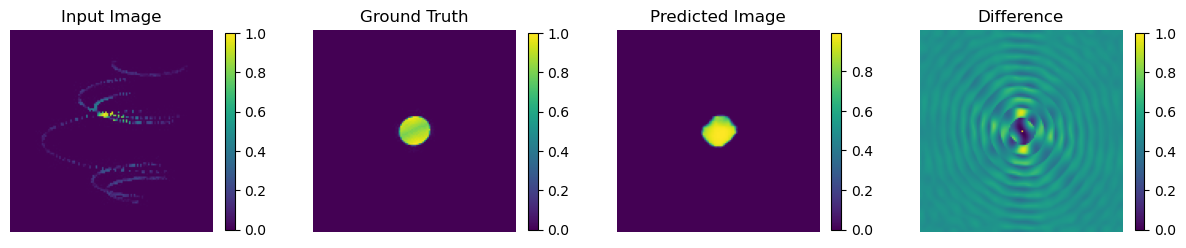

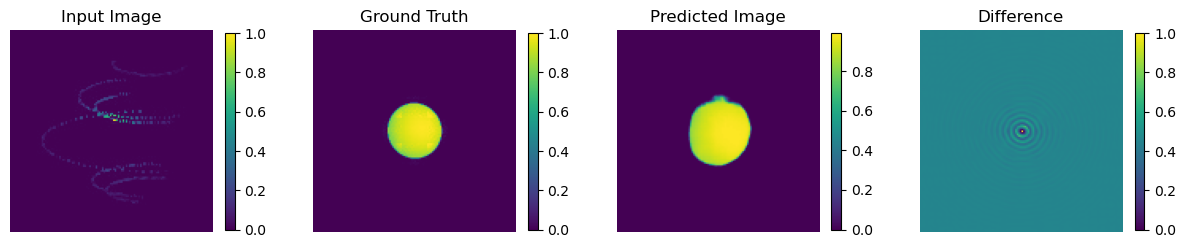

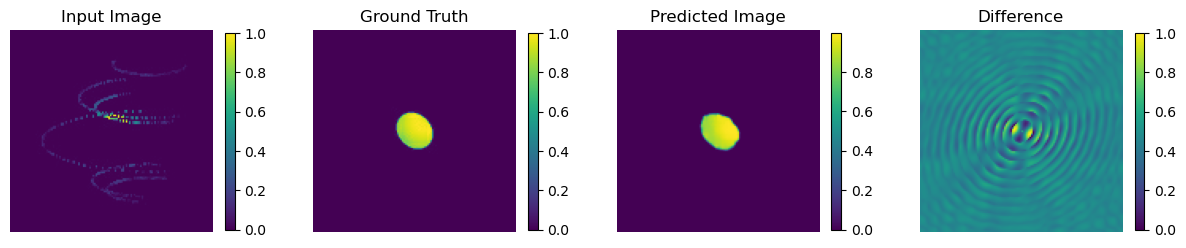

In [11]:
counter = 0
for inp, tar in test_dataset.take(20):
    print(rmse(inp, tar))
    mfn.generate_images(generator, inp, tar, show_diff=True, sampling=False, save_image=True, counter=counter)
    counter += 1